In [1]:
# using an XGBoost model, the goal is to predict lap times
# TRAINING DATA: all data ingested from the 2024 season

In [2]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data Gathering/Preprocessing

In [3]:
# pull the lap times data and race conditions data
lap_data = pd.read_csv("../data/lap_time_df.csv")
weather_data = pd.read_csv("../data/race_conditions_df.csv")

In [4]:
# merge the two dataframes
data = lap_data.merge(weather_data, on="race_id", how="left")

# create a boolean column for rain
data["is_rain"] = data["rain"].astype(int)

# convert categorical columns (compound, track)
# compound (one hot encoding)
compound_ohe = pd.get_dummies(data["compound"], prefix="compound")

final_df = pd.concat([data, compound_ohe], axis=1)

# track (target encoding -> each track has roughly the same lap time per track)  MAKE SURE THERE IS NO DATA LEAKAGE (split train/test first then apply)
# WHAT IS TARGET ENCODING -> this is taking a categorical column and replacing it with some numerical value derived from that column
# NOTE: track x will always have lap times around 0-1 and then track y will always have lap times around 1-2 (for example)

In [5]:
final_df.columns

Index(['race_id', 'year', 'round', 'track', 'driver', 'team', 'race_lap',
       'stint', 'compound', 'tire_age', 'lap_time_sec', 'is_inlap',
       'is_outlap', 'circuit_length(km)', 'track_temp', 'air_temp', 'rain',
       'is_rain', 'compound_HARD', 'compound_INTERMEDIATE', 'compound_MEDIUM',
       'compound_SOFT', 'compound_WET'],
      dtype='object')

In [28]:
# target encode track column
# tracks should NOT be split, the model needs all the information from each track to be able to simulate a lap time
# kfold target encoding helper function
def kfold_target_encode(df, cat_col, target_col, n_splits=5):
    """
    Target encoding method for the categorical 'track' column via K-Fold cross validation.
    Splits by race_id to prevent data leakage.
    """
    df = df.copy()

    unique_races = df["race_id"].unique()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=44)

    # find a numerical feature to represent track
    global_mean = df[target_col].mean()
    print(global_mean)
    encoded = pd.Series(index=df.index, dtype=float)

    # Split races (not individual laps)
    for train_race_idx, val_race_idx in kf.split(unique_races):
        train_races = unique_races[train_race_idx]
        val_races = unique_races[val_race_idx]
        
        # Get all laps from train and validation races
        train_fold = df[df["race_id"].isin(train_races)]
        val_fold = df[df["race_id"].isin(val_races)]
        
        # Calculate means from training races only
        means = train_fold.groupby(cat_col)[target_col].mean()
        
        # Apply to validation races
        encoded.loc[val_fold.index] = val_fold[cat_col].map(means)
    
    # Fallback for any missing values
    encoded.fillna(global_mean, inplace=True)
    
    return encoded

In [29]:
# implement target encoding
final_df["track_te"] = kfold_target_encode(final_df, "track", "lap_time_sec")

90.32207334648365


## Feature Engineering
I want to include some extra columns that might improve model output.

In [8]:
# feature engineering
"""IDEAS
- fuel consumption
- delta of temperature (air temp - track temp)
"""

final_df["tire_age_squared"] = final_df["tire_age"] ** 2  # Non-linear degradation
final_df["fuel_effect"] = final_df["race_lap"] / final_df["race_lap"].max()  # Fuel burn
final_df["temp_delta"] = final_df["track_temp"] - final_df["air_temp"]  # Grip conditions

In [9]:
# X = final_df[["race_lap", "tire_age", "stint", "track_temp", "air_temp", "is_rain", "track_te", "compound_HARD", "compound_INTERMEDIATE", "compound_MEDIUM", "compound_SOFT", "compound_WET", "circuit_length(km)"]]
X = final_df[["tire_age_squared", "fuel_effect", "temp_delta", "race_lap", "tire_age", "stint", "track_temp", "air_temp", "is_rain", "track_te", "compound_HARD", "compound_INTERMEDIATE", "compound_MEDIUM", "compound_SOFT", "compound_WET", "circuit_length(km)"]]
y = final_df["lap_time_sec"]

# SANITY CHECK
print("X and y SIZES")
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

X and y SIZES
Feature shape: (24841, 16)
Target shape: (24841,)


In [10]:
# Create a baseline lookup table from your data
def create_baseline_reference():
    """
    Calculate baseline lap times for each track from your historical data
    """
    baseline_ref = final_df.groupby('track').agg({
        'lap_time_sec': ['mean', 'median', 'std', 'min']
    }).round(2)
    
    baseline_ref.columns = ['avg_laptime', 'median_laptime', 'std', 'fastest_lap']
    
    return baseline_ref

baseline_reference = create_baseline_reference()
# print(baseline_reference)

In [11]:
# baseline_reference.to_csv("baseline_references.csv")

## Data Visualizations

In [12]:
import seaborn as sns

Text(0.5, 1.0, 'Tire Age vs Lap Time')

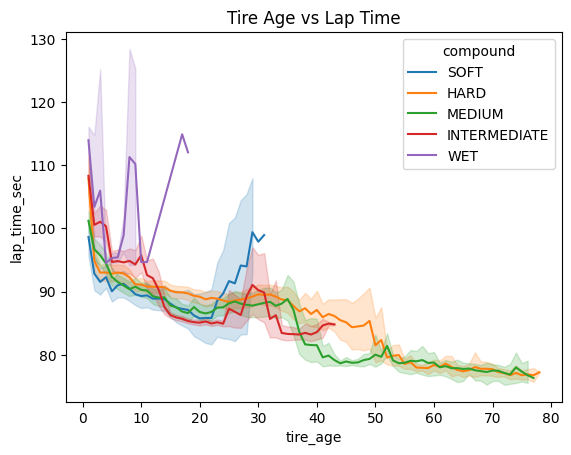

In [13]:
# plot tire age vs lap time sec (colored by compound)
# GOAL: should see that degradation still exists (if there is no then I over encoded)
sns.lineplot(data=final_df, x="tire_age", y="lap_time_sec", hue="compound")
plt.title("Tire Age vs Lap Time")

Text(0.5, 1.0, 'Lap Time Model Input Correlations')

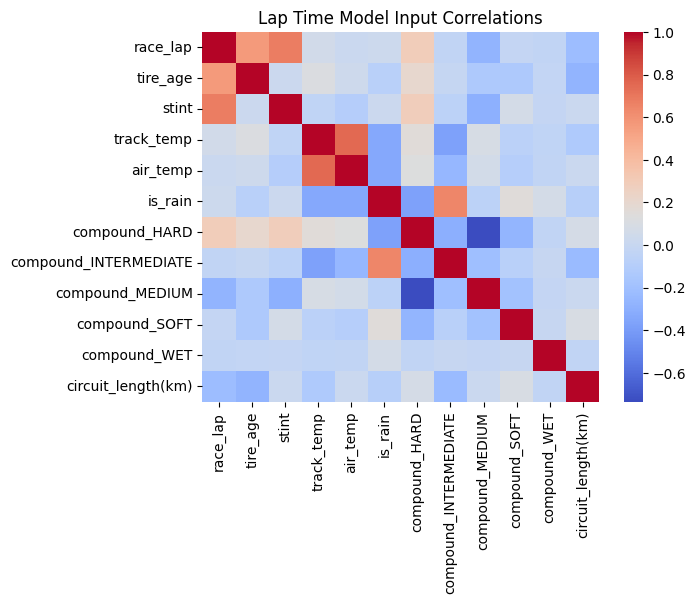

In [14]:
corr_inputs = X[["race_lap", "tire_age", "stint", "track_temp", "air_temp", "is_rain", "compound_HARD", "compound_INTERMEDIATE", "compound_MEDIUM", "compound_SOFT", "compound_WET", "circuit_length(km)"]]
sns.heatmap(corr_inputs.corr(), cmap="coolwarm")
plt.title("Lap Time Model Input Correlations")

## Model Building

MODEL ISSUE: the testing set got "slower" track compared to the training set, so because of this the model was trained on faster tracks, so it learned from fast tracks/conditions and then the test was on slower tracks, making the accuracy very bad

SOLUTION: Give the model ALL tracks, so the model will know all lap times for all tracks, because our end goal is to make a race strategy simulator not a future race predictor
- every track will have representation in the model
- the target encoding will have actual data
- model will learn the BASELINE speed for the tracks

THE END GOAL IS NOT A PREDICTOR BUT A SIMULATOR!

This will allow our end model to be more responsive to a "what if we pit 5 laps later?", "what if it is hotter?", etc

In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
X.shape

(24841, 16)

In [18]:
print(X.head())

   tire_age_squared  fuel_effect  temp_delta  race_lap  tire_age  stint  \
0              16.0     0.012821    4.817626       1.0       4.0    1.0   
1              16.0     0.012821    4.817626       1.0       4.0    1.0   
2              16.0     0.012821    4.817626       1.0       4.0    1.0   
3              16.0     0.012821    4.817626       1.0       4.0    1.0   
4              16.0     0.012821    4.817626       1.0       4.0    1.0   

   track_temp   air_temp  is_rain   track_te  compound_HARD  \
0   22.825952  18.008326        0  90.322073          False   
1   22.825952  18.008326        0  90.322073          False   
2   22.825952  18.008326        0  90.322073          False   
3   22.825952  18.008326        0  90.322073          False   
4   22.825952  18.008326        0  90.322073          False   

   compound_INTERMEDIATE  compound_MEDIUM  compound_SOFT  compound_WET  \
0                  False            False           True         False   
1                  Fal

In [20]:
# build DMatrix structures to allow faster training and less memory use for the XGB model
xgb_matrix = xgb.DMatrix(X, label=y)

# define parameters
# params = {
#     "objective": "reg:squarederror",
#     "eval_metric": "rmse",
#     "learning_rate": 0.03,
#     "max_depth": 3,
#     "min_child_weight": 10,
#     "subsample": 0.7,
#     "colsample_bytree": 0.7,
#     "lambda": 5.0,   # L2
#     "alpha": 1.0,    # L1
#     "seed": 42
# }
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_weight": 10,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,      # L2 regularization
    "alpha": 0.3,       # L1 regularization
    "seed": 42
}

evals = [(xgb_matrix, "train")]

# IMPORTANT: pass a dict to collect evaluation results
evals_result = {}

model = xgb.train(
    params=params,
    dtrain=xgb_matrix,
    num_boost_round=500,
    evals=[(xgb_matrix, "train")],
    early_stopping_rounds=25,
    evals_result=evals_result,
    verbose_eval=50
)

# predictions
preds = model.predict(xgb_matrix)
rmse = np.sqrt(mean_squared_error(y, preds))
r2 = r2_score(y, preds)

# SANITY PRINTS
print("*" * 10)
print("MODEL RESULTS (trained on all data)")
print(f"RMSE: {rmse:.3f} seconds")
print(f"R2: {r2:.3f} seconds")


[0]	train-rmse:11.69230
[50]	train-rmse:4.79266
[100]	train-rmse:3.49257
[150]	train-rmse:3.00221
[200]	train-rmse:2.70160
[250]	train-rmse:2.52373
[300]	train-rmse:2.38819
[350]	train-rmse:2.29067
[400]	train-rmse:2.22174
[450]	train-rmse:2.15240
[499]	train-rmse:2.09619
**********
MODEL RESULTS (trained on all data)
RMSE: 2.096 seconds
R2: 0.970 seconds


 ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '(km)'] ['compound_INTERMEDIATE', 'tire_age', 'tire_age_squared', 'is_rain', 'circuit_length(km)', 'fuel_effect', 'temp_delta', 'race_lap', 'stint', 'track_temp', 'air_temp', 'track_te', 'compound_HARD', 'compound_MEDIUM', 'compound_SOFT', 'compound_WET']

In [21]:
# save the model
model.save_model("lap_time_predictor.json")

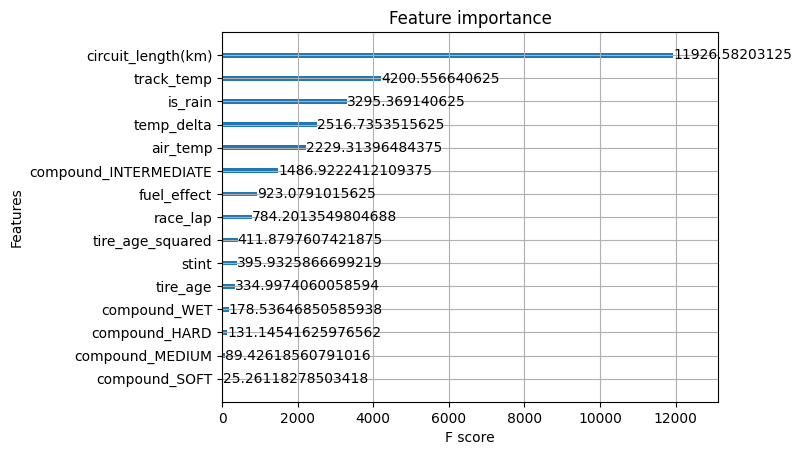

In [27]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

## Model Optimization

Text(0.5, 1.0, 'Predicted Lap Time vs Actual Lap Time')

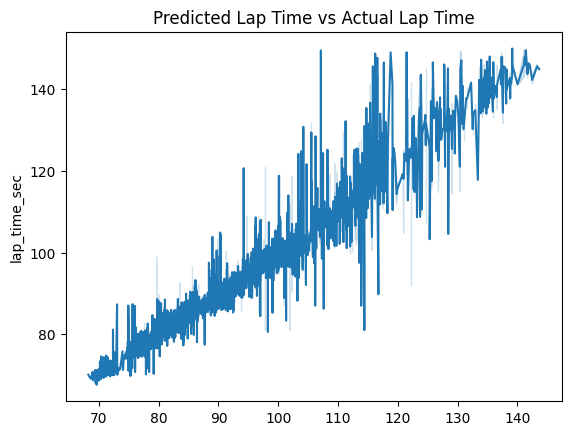

In [ ]:
# plot tire age vs lap time sec (colored by compound)
# GOAL: should see that degradation still exists (if there is no then I over encoded)
sns.lineplot(x=preds, y=y)
plt.title("Predicted Lap Time vs Actual Lap Time")

input -> interactive translation

- "track" -> dropdown prix option
- "circuit length" -> pull from track table
- "tire_age_squared"
- "fuel_effect"
- "temp_delta"
- "race_lap"  -> user input
- "tire_age"
- "stint"
- "track_temp"
- "air_temp"  _. pull data from weatherAPI?
- "is_rain" -> radio
"track_te"
- COMPOUND ( will need to be a radio button and then will need to translate the other columns)
"compound_HARD"
"compound_INTERMEDIATE"
"compound_MEDIUM"
"compound_SOFT"
"compound_WET"
